In [1]:
import os
os.chdir("../")

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [2]:
from config import *
from data import *
from train import *
from eval import *
from vital import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


## Customize Configuration

In [3]:
# (customize) configs
overwrite = False
model_name = 'test_succ_inc2'
text_config['cl']['die7d'] = True # udpate text_config here if needed
text_config['ts']['sumb'] = False
text_config['ts']['simple'] = False
text_config['ts']['event1'] = False
text_config['ts']['histogram'] = False

# model_name = model_name + "___" + "_".join(get_true_components(text_config))

update_config(
    y_col = 'description_succ_inc',
    y_levels = ['High amount of consecutive increases.', 'Moderate amount of consecutive increases.', 'Low amount of consecutive increases.'],
    y_pred_levels = ['High amount of consecutive increases.', 'Moderate amount of consecutive increases.', 'Low amount of consecutive increases.'],
    txt2ts_y_cols = ['description_succ_inc'],
    
    text_col = 'ts_description',
    downsample = True,
    downsample_levels = ['High amount of consecutive increases.', 'Moderate amount of consecutive increases.', 'Low amount of consecutive increases.'],
    downsample_size = 10000,
    model_name = model_name,
    embedded_dim = 512,
    batch_size = 512, # Data loader settings
    patience = 100, # Training settings
    num_saves = 10,
    num_epochs = 10,
    init_lr = 5e-5,
    text_config = text_config,
    **{'3d': False}  # Add this line
)
config_dict = get_config_dict()


#  result saving directory
output_dir = './results/'+config_dict['model_name']
model_clip_path = output_dir+'/model_clip.pth' 
eval_clip_path = output_dir+'/evals_clip.pth'
model_path = output_dir+'/model.pth' 
eval_path = output_dir+'/evals.pth'
config_path = output_dir+'/config.pth'

In [4]:
# run preprocess.py to ready the data
with open('main_preprocess.py', 'r') as file:
    exec(file.read())


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1835    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.0s
[Parallel(n_jobs=9)]: Done 2596 tasks      | elapsed:    4.5s
[Parallel(n_jobs=9)]: Done 63298 tasks      | elapsed:   13.0s
[Parallel(n_jobs=9)]: Done 65100 out of 65100 | elapsed:   13.2s finished


replace 'text' with:  ts_description
text
Moderate amount of consecutive increases. Low amount of flat lines.         19417
Moderate amount of consecutive increases. Moderate amount of flat lines.    13240
Moderate amount of consecutive increases. High amount of flat lines.        10253
Low amount of consecutive increases. High amount of flat lines.              9524
High amount of consecutive increases. Low amount of flat lines.              8642
Name: count, dtype: int64

Sample of patients with positive labels:
TestID
508     8
707     8
1903    8
817     8
1414    7
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.4s
[Parallel(n_jobs=9)]: Done 60894 tasks      | elapsed:    8.5s
[Parallel(n_jobs=9)]: Done 61197 out of 61197 | elapsed:    8.5s finished


replace 'text' with:  ts_description
text
Moderate amount of consecutive increases. High amount of flat lines.        19975
Low amount of consecutive increases. High amount of flat lines.             12147
Moderate amount of consecutive increases. Low amount of flat lines.          9080
Moderate amount of consecutive increases. Moderate amount of flat lines.     7118
High amount of consecutive increases. High amount of flat lines.             4975
Name: count, dtype: int64
After downsampling:
description_succ_inc
High amount of consecutive increases.        10000
Moderate amount of consecutive increases.    10000
Low amount of consecutive increases.         10000
Name: count, dtype: int64
After downsampling:
description_succ_inc
Moderate amount of consecutive increases.    10000
Low amount of consecutive increases.          6582
High amount of consecutive increases.         5930
Name: count, dtype: int64


final distribution of text prediction
description_succ_inc
High amount of consec

In [5]:

# description_succ_inc
# description_succ_unc
# description_histogram
# description_ts_event
# ts_description
print(df_train['description_succ_inc'].value_counts())
c = 0


# for i in df_train[df_train['description_succ_unc'] == "High amount of flat lines."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break

# for i in df_train[df_train['description_succ_inc'] == "Low amount of consecutive increases."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
        # break

# for i in df_train[df_train['description_succ_inc'] == "Low amount of consecutive increases."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break


# for i in df_train[df_train['description_histogram'] == "High variability."].index:
#     plot_ts(df_train, i)
#     c += 1
#     if c > 10:
#         break


description_succ_inc
High amount of consecutive increases.        10000
Moderate amount of consecutive increases.    10000
Low amount of consecutive increases.         10000
Name: count, dtype: int64


In [6]:
# # for testing purposes way 1
# %load_ext autoreload
# %autoreload 1
# %aimport train

# # way 2 if way 1 not working
# %load_ext autoreload
# %autoreload 2
# import importlib
# import train
# importlib.reload(train)

### Customize VITAL Model

In [6]:
# overwrite = False
# customize model
if overwrite or not os.path.exists(model_path):    
    # check if ts_f_dim is already in the memory
    if 'ts_f_dim' not in locals():
        # just to get the dimension out
        if config_dict['3d']:
            ts_f_dim, tx_f_dim_ls, labels_dim = get_features3d(df_train.iloc[:1,:], config_dict, text_col_ls = config_dict['text_col_ls'])
        else:
            ts_f_dim, tx_f_dim, labels_dim = get_features(df_train.iloc[:1,:], config_dict)
    
    ts_encoder = None
    ts_decoder = None
    if config_dict['3d']:
        model = VITAL3D(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim_ls[0].shape[1],
                    n_text=len(tx_f_dim_ls),
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    else:
        model = VITAL(
                    ts_dim=ts_f_dim.shape[1],
                    text_dim=tx_f_dim.shape[1],
                    output_dim=config_dict['embedded_dim'],
                    ts_encoder=ts_encoder,
                    ts_decoder=ts_decoder,
                    clip_mu = True
                )
    update_config(model_init = model)
    config_dict = get_config_dict()
    

    
    train_eval_metrics_ts2txt_list = []
    test_eval_metrics_ts2txt_list = []
    train_eval_metrics_txt2ts_list = []
    test_eval_metrics_txt2ts_list = []
    train_losses = []
    test_losses = []

    
    # ------------------------- ready output directory -------------------------
    import shutil
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    config_dict['model_init'] = model
    torch.save(config_dict, config_path)
    # overwrite = False # reset overwrite to False
else:
    config_dict = torch.load(config_path, map_location=torch.device(device))
    model = config_dict['model_init']
    print(nn_summary(model))
    model.device = device

    

Layer (type:depth-idx)                                            Param #
VITAL                                                             1
├─TSVAEEncoder: 1-1                                               --
│    └─LocalNorm: 2-1                                             --
│    └─Sequential: 2-2                                            --
│    │    └─MultiLSTMEncoder: 3-1                                 11,111,424
│    │    └─LayerNorm: 3-2                                        512
│    │    └─Linear: 3-3                                           131,584
│    │    └─LeakyReLU: 3-4                                        --
│    │    └─LayerNorm: 3-5                                        1,024
│    │    └─Linear: 3-6                                           131,328
│    │    └─LeakyReLU: 3-7                                        --
│    │    └─LayerNorm: 3-8                                        512
│    └─Linear: 2-3                                                65,792
│  

## Train clip 

### Train ts and txt encoders using $\mu$

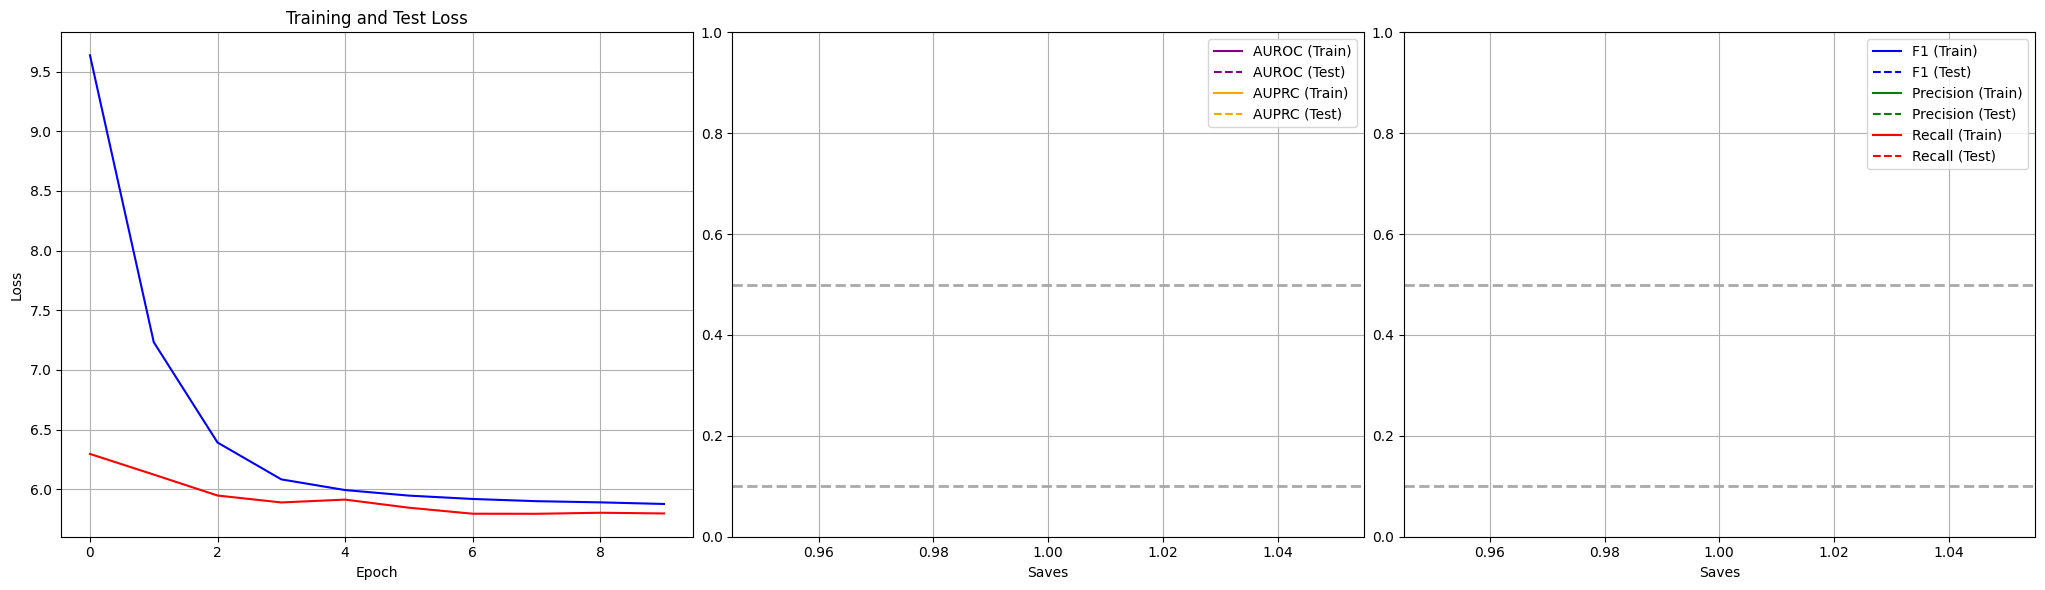

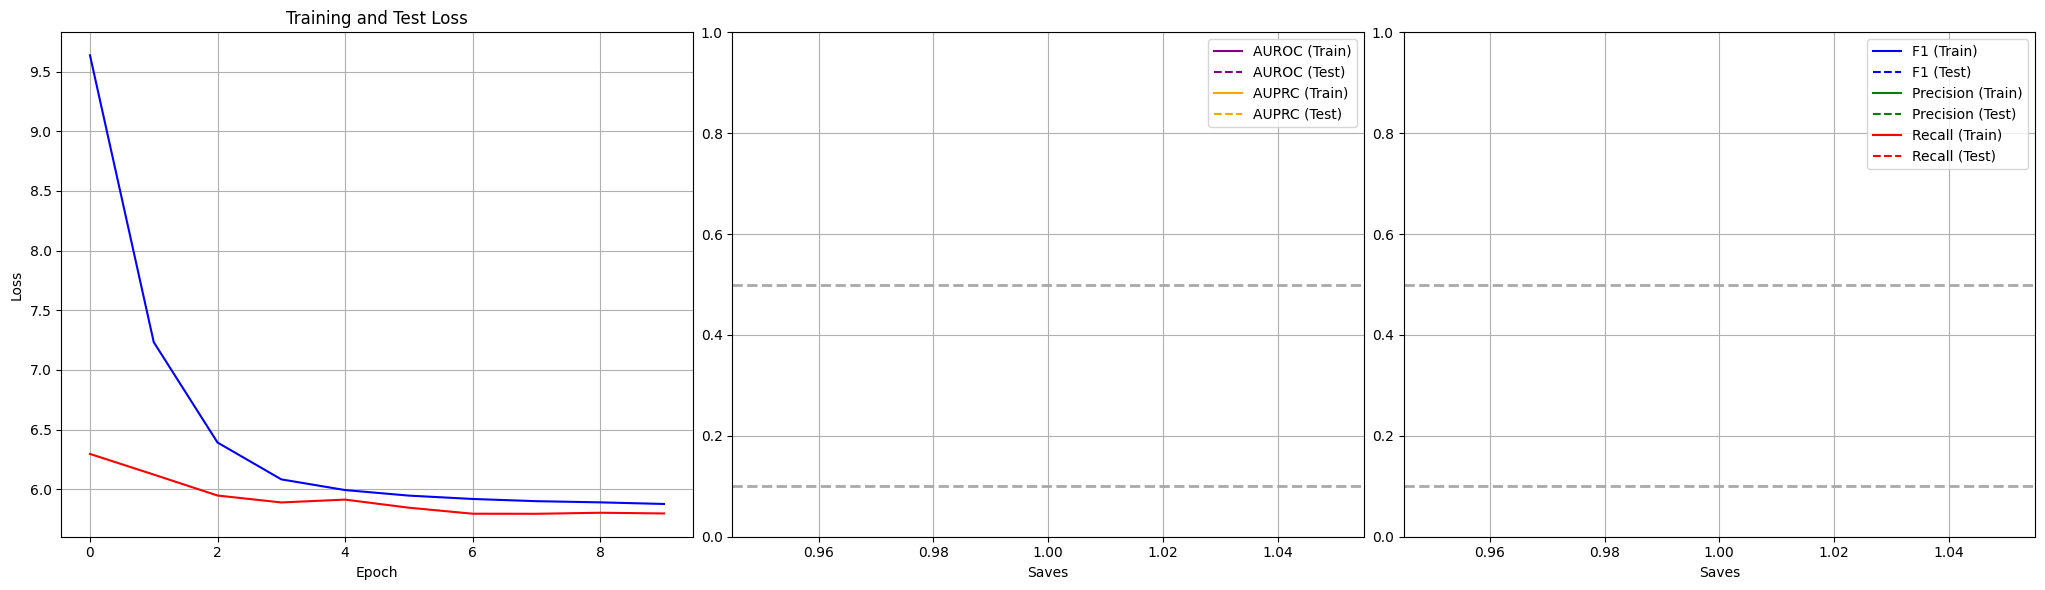

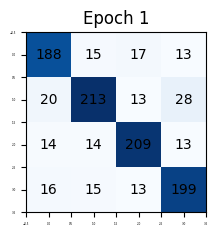

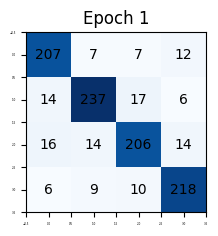

In [7]:
# overwrite = False
if overwrite or not os.path.exists(model_clip_path):

    # ------------------------- ready training for clip -------------------------
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=100,      
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-4,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more

    
    for i in range(100):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        target_type = 'by_target',
                                                        train_type='clip',
                                                        alpha = 1/1000)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')
    
        # print results 
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True, plot_confusion_matrices=True)
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
else:
    model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
    model.eval()
    eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
    eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    
    

### Train ts encoder $\sigma$

In [8]:

if overwrite:
    
    model.clip_mu = False
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = True
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = False
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")

    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-4,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=50,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more




    for i in range(50):  # config_dict['num_saves']
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs'], 
                                                        train_type='clip')
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
        # every num_epochs, evaluate the model
        model.eval()
        if config_dict['3d']:
            train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

        else:
            train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
            test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
            train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
            test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

        train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
        test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
        eval_dict_ts2txt = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_ts2txt_list,
                    'test_evals': test_eval_metrics_ts2txt_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        eval_dict_txt2ts = {'train_losses': train_losses,
                    'test_losses': test_losses,
                    'train_evals': train_eval_metrics_txt2ts_list,
                    'test_evals': test_eval_metrics_txt2ts_list }
        eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        print("-" * 70)
        print(f"Metric     |  Training  |  Testing")
        print("-" * 70)
        print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_clip_path)
        torch.save(eval_dict_ts2txt, output_dir+'/evals_clip_ts2txt.pth')
        torch.save(eval_dict_txt2ts, output_dir+'/evals_clip_txt2ts.pth')

    eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=True)
    eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=True, plot_confusion_matrices=True)
    

## Train VAE decoder

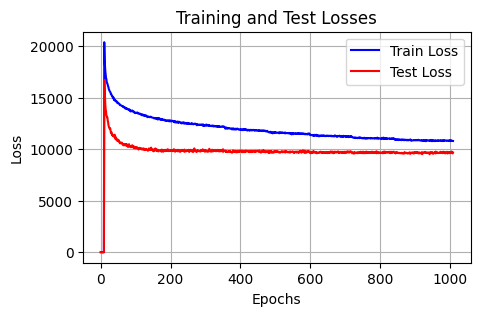

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


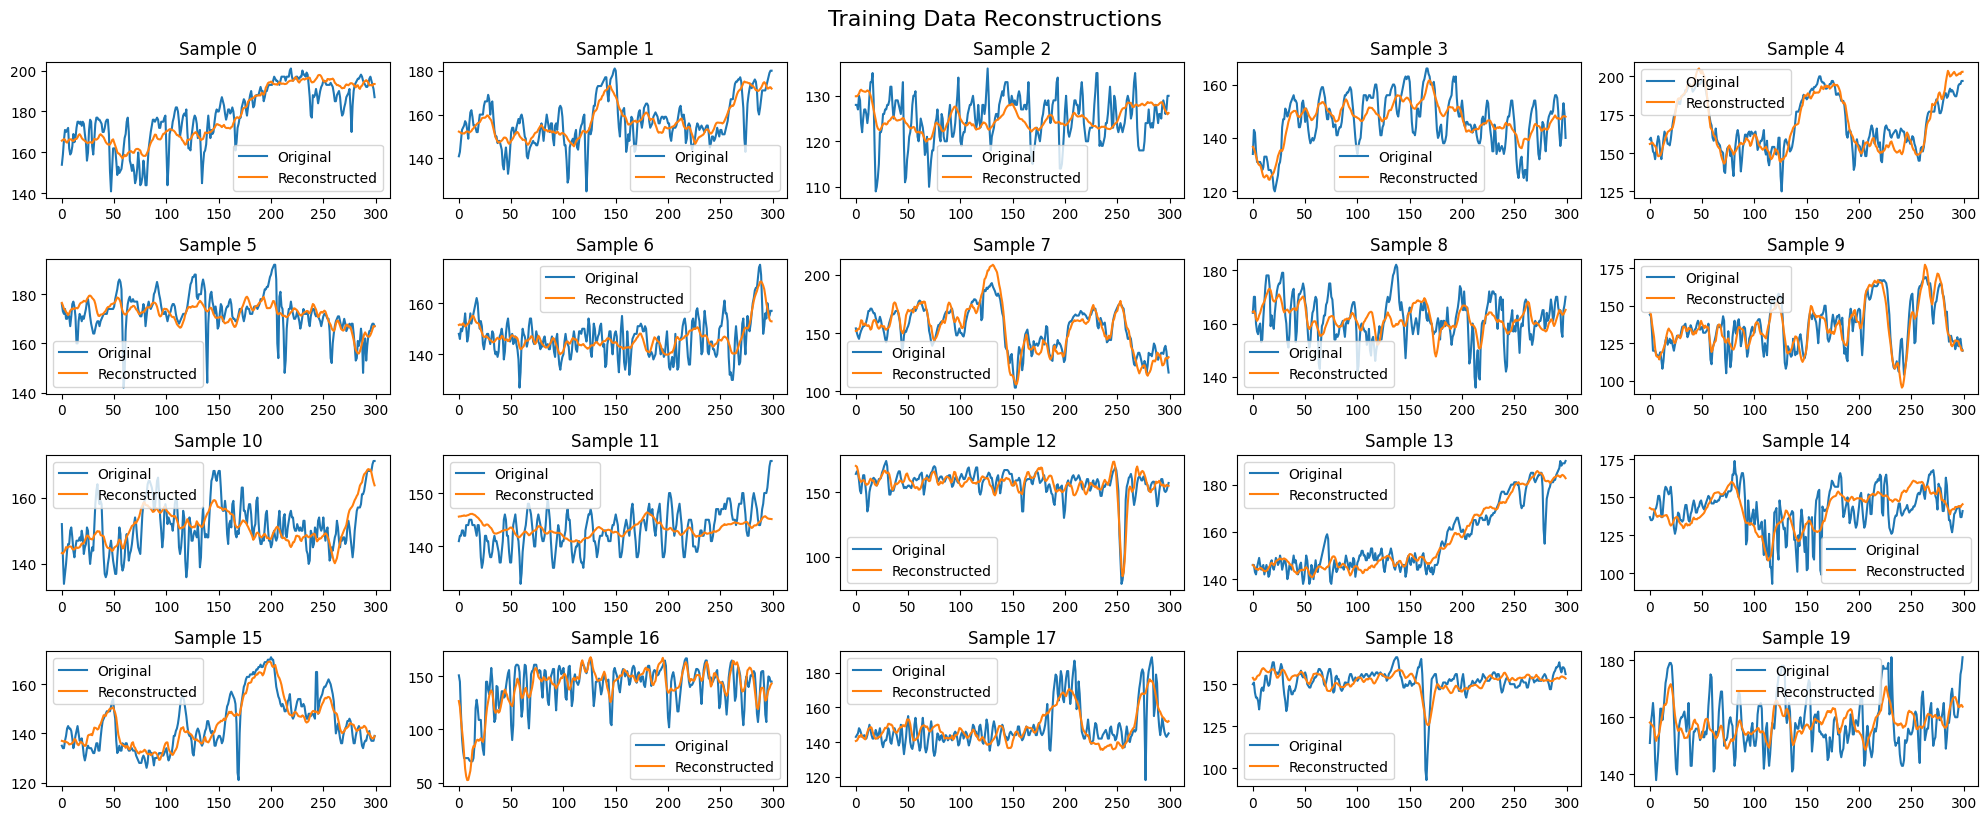

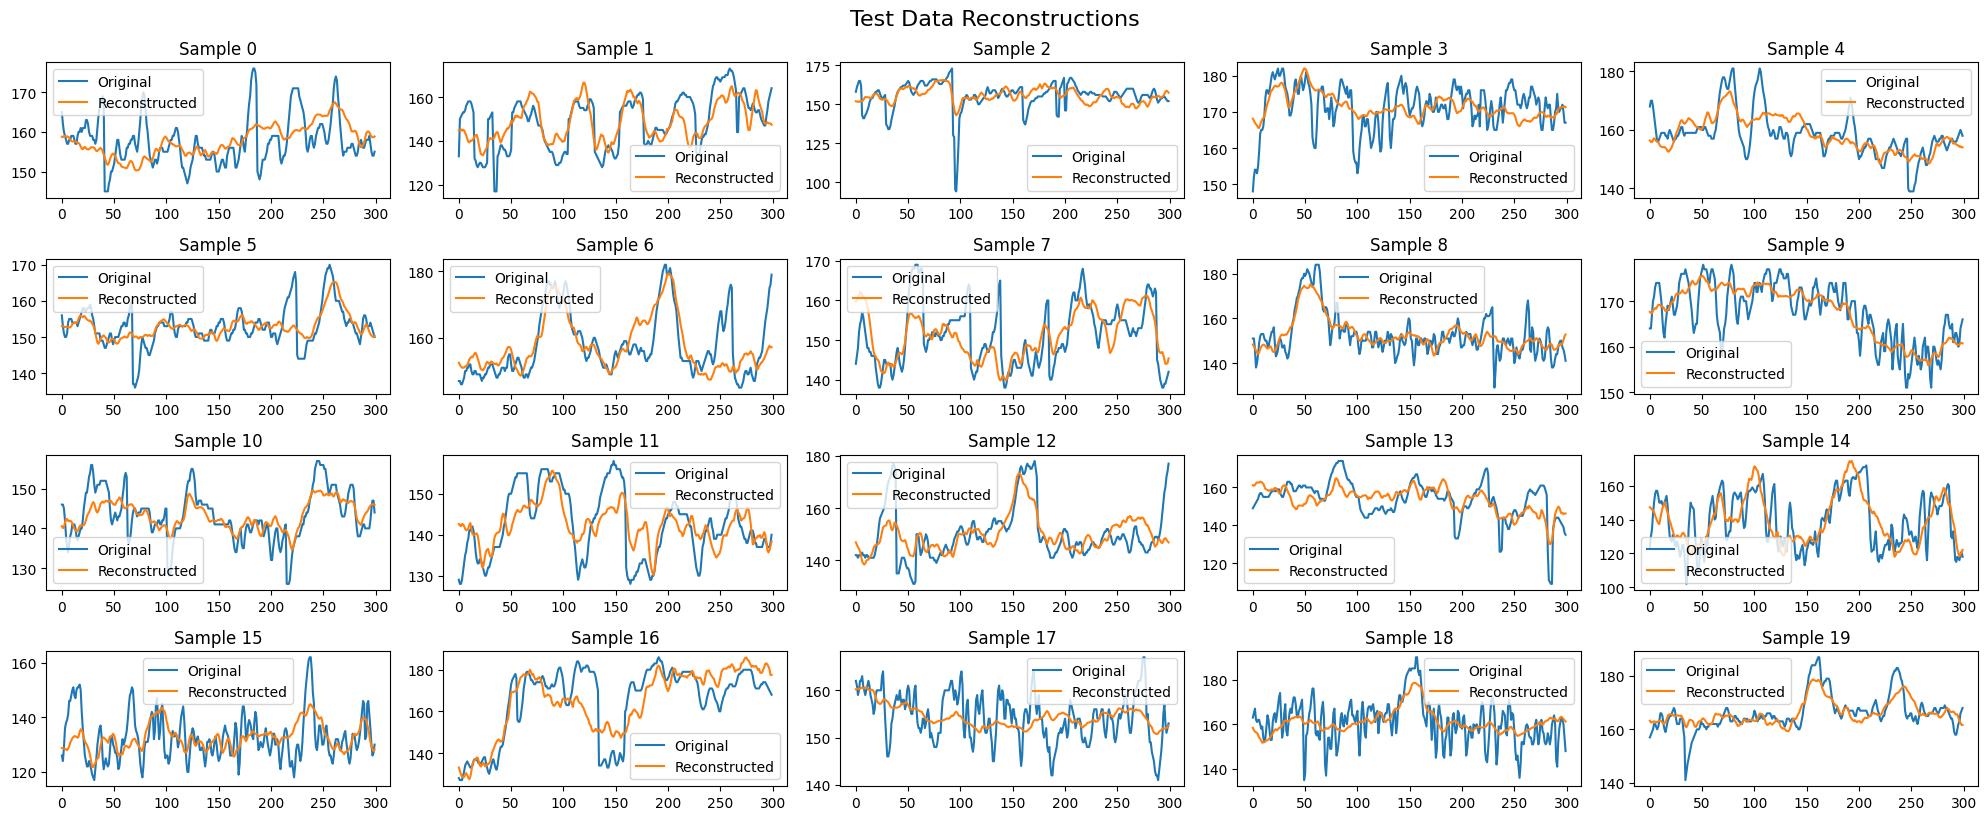

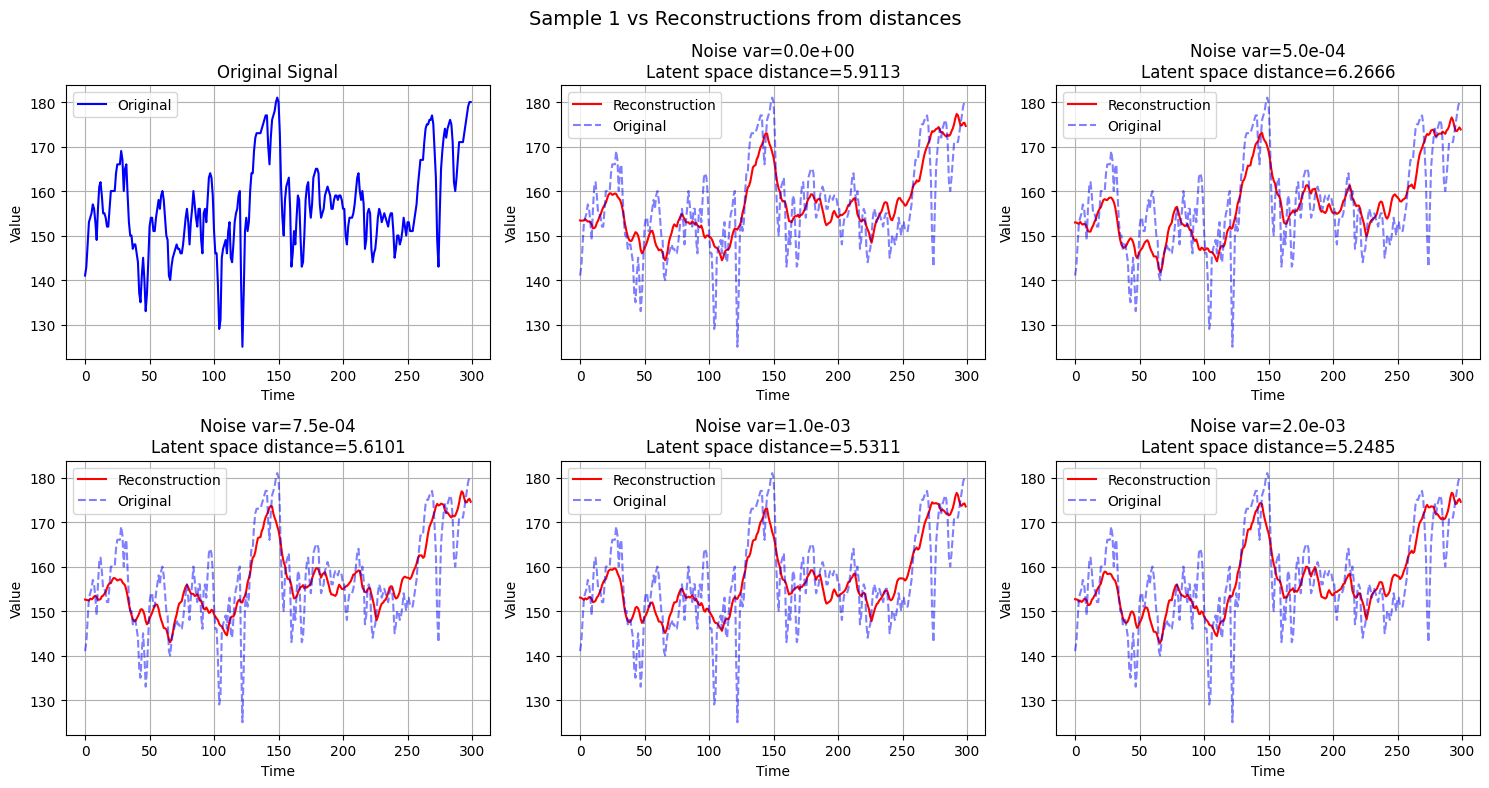

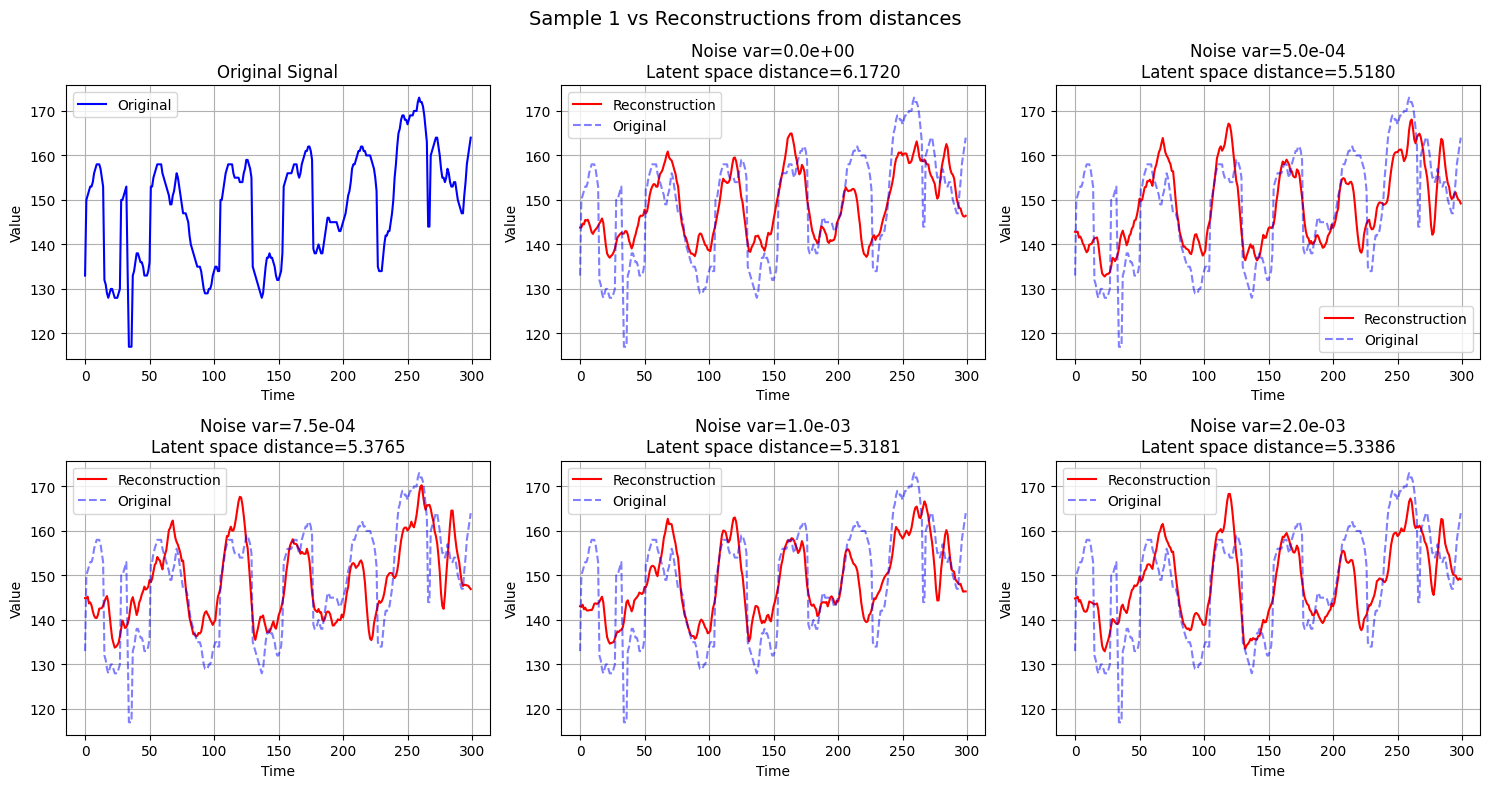

In [9]:
overwrite = False
from_clip = False
if overwrite:
    if from_clip or not os.path.exists(model_path):
        # load model and eval from checkpoint of clip
        model.load_state_dict(torch.load(model_clip_path, map_location=torch.device(device)))
        eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
        eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
        train_losses = eval_dict_ts2txt['train_losses']
        test_losses = eval_dict_ts2txt['test_losses']
        # train_eval_metrics_ts2txt_list = eval_dict_ts2txt['train_evals']
        # test_eval_metrics_ts2txt_list = eval_dict_ts2txt['test_evals']
        # train_eval_metrics_txt2ts_list = eval_dict_txt2ts['train_evals']
        # test_eval_metrics_txt2ts_list = eval_dict_txt2ts['test_evals']
    else: 
        model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
        train_losses = losses['train_losses']
        test_losses = losses['test_losses']
        # eval_dict_ts2txt = torch.load(output_dir+'/evals_clip_ts2txt.pth', map_location=torch.device(device))
        # eval_dict_txt2ts = torch.load(output_dir+'/evals_clip_txt2ts.pth', map_location=torch.device(device))
        # train_eval_metrics_ts2txt_list = eval_dict_ts2txt['train_evals']
        # test_eval_metrics_ts2txt_list = eval_dict_ts2txt['test_evals']
        # train_eval_metrics_txt2ts_list = eval_dict_txt2ts['train_evals']
        # test_eval_metrics_txt2ts_list = eval_dict_txt2ts['test_evals']
    
    # ------------------------- ready training for vae decoder -------------------------
    # 1. Freeze encoders
    for param in model.ts_encoder.parameters():
        param.requires_grad = False
    for param in model.text_encoder.parameters():
        param.requires_grad = False
    # 2. Unfreeze logvar_layer in ts_encoder to trainable
    for param in model.ts_encoder.logvar_layer.parameters():
        param.requires_grad = False
    # 3. Unfreeze decoder
    for param in model.ts_decoder.parameters():
        param.requires_grad = True
    # Verify parameters
    print("Checking trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}")
    
    # Create optimizer with only trainable parameters
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3,
        weight_decay=1e-4
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.9,         
        patience=200,       
        verbose=True,
        min_lr=1e-20,        
        threshold=1e-3,      
        cooldown=20          
    )

    kl_annealer = KLAnnealer(start=0.0, 
                                end=1.0, 
                                epochs=10000) # for the first 1000 epochs, favor reconstruction more


    
    for i in range(config_dict['num_saves']):  # n_evals
        train_losses_tmp, test_losses_tmp = train_vital(model, 
                                                        train_dataloader,
                                                        test_dataloader, 
                                                        optimizer, 
                                                        scheduler,
                                                        kl_annealer,
                                                        num_epochs=config_dict['num_epochs']*10, 
                                                        train_type='joint',
                                                        alpha = 1)
        train_losses = train_losses + train_losses_tmp
        test_losses = test_losses + test_losses_tmp
#         # every num_epochs, evaluate the model
#         model.eval()
#         if config_dict['3d']:
#             train_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_train)
#             test_eval_metrics_ts2txt = eval_clip3d_ts2txt(model, evalclipts2txt_test)
#             train_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_train)
#             test_eval_metrics_txt2ts = eval_clip3d_txt2ts(model, evalcliptxt2ts_test)

#         else:
#             train_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_train)
#             test_eval_metrics_ts2txt = eval_clip_ts2txt(model, evalclipts2txt_test)
#             train_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_train)
#             test_eval_metrics_txt2ts = eval_clip_txt2ts(model, evalcliptxt2ts_test)

#         train_eval_metrics_ts2txt_list.append(train_eval_metrics_ts2txt)
#         test_eval_metrics_ts2txt_list.append(test_eval_metrics_ts2txt)
#         eval_dict_ts2txt = {'train_losses': train_losses,
#                     'test_losses': test_losses,
#                     'train_evals': train_eval_metrics_ts2txt_list,
#                     'test_evals': test_eval_metrics_ts2txt_list }
#         eval_dict_eng = eng_eval_metrics(eval_dict_ts2txt, binary=True, plot=False)
#         print("-" * 70)
#         print(f"Metric     |  Training  |  Testing")
#         print("-" * 70)
#         print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
#         print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
#         print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
#         print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
#         print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
#         print("-" * 70)

        # train_eval_metrics_txt2ts_list.append(train_eval_metrics_txt2ts)
        # test_eval_metrics_txt2ts_list.append(test_eval_metrics_txt2ts)
        # eval_dict_txt2ts = {'train_losses': train_losses,
        #             'test_losses': test_losses,
        #             'train_evals': train_eval_metrics_txt2ts_list,
        #             'test_evals': test_eval_metrics_txt2ts_list }
        # eval_dict_eng = eng_eval_metrics(eval_dict_txt2ts, binary=False, plot=False)
        # print("-" * 70)
        # print(f"Metric     |  Training  |  Testing")
        # print("-" * 70)
        # print(f"F1        |   {eval_dict_eng['train_f1'][-1]:.3f}   |   {eval_dict_eng['test_f1'][-1]:.3f}")
        # print(f"Precision |   {eval_dict_eng['train_precision'][-1]:.3f}   |   {eval_dict_eng['test_precision'][-1]:.3f}")
        # print(f"Recall    |   {eval_dict_eng['train_recall'][-1]:.3f}   |   {eval_dict_eng['test_recall'][-1]:.3f}")
        # print(f"AUROC     |   {eval_dict_eng['train_auroc'][-1]:.3f}   |   {eval_dict_eng['test_auroc'][-1]:.3f}")
        # print(f"AUPRC     |   {eval_dict_eng['train_auprc'][-1]:.3f}   |   {eval_dict_eng['test_auprc'][-1]:.3f}")
        # print("-" * 70)

        # save model and losses
        torch.save(model.state_dict(), model_path)
        torch.save({'train_losses': train_losses,
                    'test_losses': test_losses}, output_dir+'/losses.pth')
        # torch.save(eval_dict_ts2txt, output_dir+'/evals_ts2txt.pth')
        # torch.save(eval_dict_txt2ts, output_dir+'/evals_txt2ts.pth')
    
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()
    losses = torch.load(output_dir+'/losses.pth', map_location=torch.device(device))
    train_losses = losses['train_losses']
    test_losses = losses['test_losses']
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(test_losses, label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Losses')
    plt.legend()
    plt.grid(True)
    plt.show()
    # eval vae
    plot_reconstructions(model, 
                        df=df_train, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Training Data Reconstructions")

    plot_reconstructions(model, 
                        df=df_test, 
                        config_dict = config_dict, 
                        text_col_ls = config_dict['text_col_ls'],
                        title="Test Data Reconstructions")

    plot_reconstruction_from_distances(model, df_train, config_dict, text_col_ls = config_dict['text_col_ls'])
    plot_reconstruction_from_distances(model, df_test, config_dict, text_col_ls = config_dict['text_col_ls'])
    

### Inference

In [ ]:
i = 1

df_infer = df_train.copy()
df = df_infer.iloc[[i]].copy()

df['text1'] = 'Low amount of consecutive increases.'
df['text2'] = 'High amount of consecutive increases.'


min_hats_per_text = 0
i = 0
while min_hats_per_text < 100:
    cts_hat, c_probs = vital1_contrast_infer(df, model, config_dict, text_cols = ['text1','text2'], var_ratio = 5+i, K =5000)
    min_hats_per_text = min([len(v) for v in cts_hat.values()])
    i+=1
ts = df.loc[:,'1':'300'].values[0]
plot_vital_contrast_reconstructions(ts, cts_hat, c_probs)


boot = 1000
res = {}
plt.figure(figsize=(8, 6))
for i, (text_condition, ts_hats) in enumerate(cts_hat.items()):
    probs = c_probs[text_condition]
    replace = ts_hats.shape[0] < boot
    idx = np.random.choice(ts_hats.shape[0], boot, replace=replace)
    ts_hats = ts_hats[idx]
    probs = probs[idx]
    
    ui = []
    for j in range(len(ts_hats)):
        o = successive_increases(ts_hats[j].detach().cpu().numpy())
        p = probs[j].detach().cpu().numpy()
        u = round(o['uuu']*3*100, 2)#  + o['u']
        wu = p*u
        ui.append(u)
    res[text_condition] = ui
    plt.hist(ui, bins=15, alpha=0.5, label=f"Verbal instruction: {text_condition}")
plt.xlabel('Consecutive increases',fontsize=14)
plt.legend(fontsize=10)
plt.show()


NameError: name 'vital_contrast_infer' is not defined

In [10]:
i = 5
distance_ratios = [10, 50, 100, 200]
threshold = 0
keep = 2
poptop = True
df_infer = df_test.copy()
df = df_infer.iloc[[i]].copy()
print(df['ts_description'].to_list()[0])

Moderate variability. Low amount of consecutive increases. High amount of flat lines.    


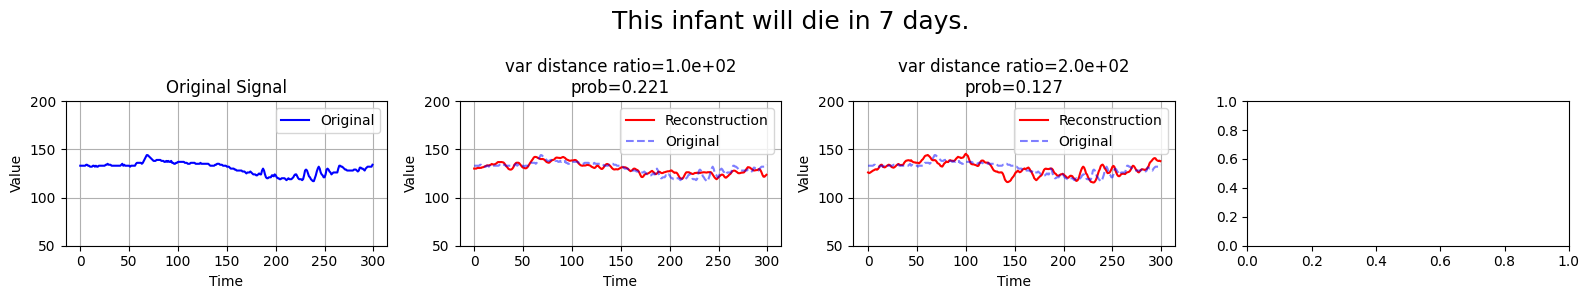

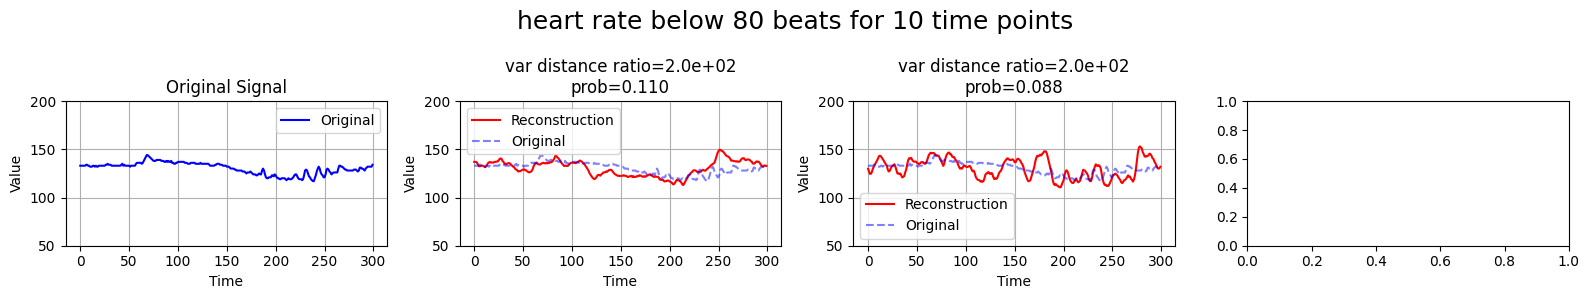

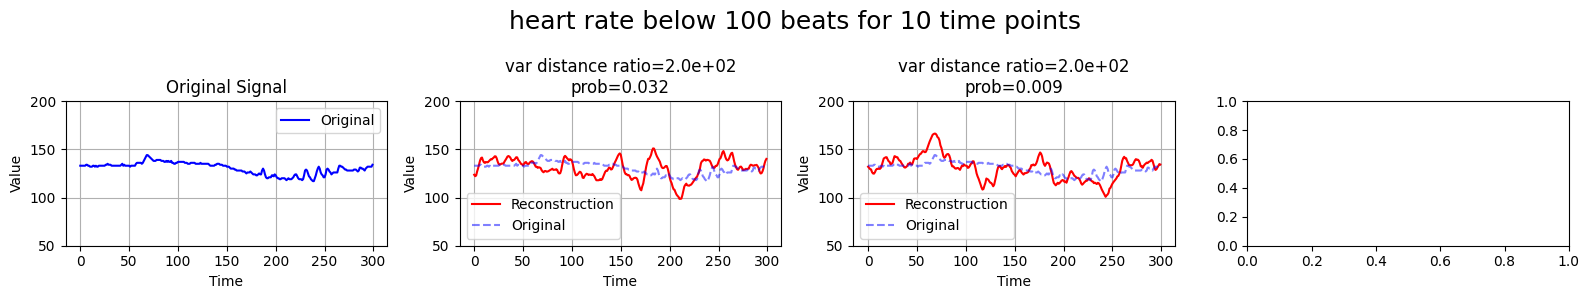

In [11]:
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['cl_event'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = "heart rate below 80 beats for 10 time points"

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])

df = df_infer.iloc[[i]].copy()
df['text1'] = "heart rate below 100 beats for 10 time points"

ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])


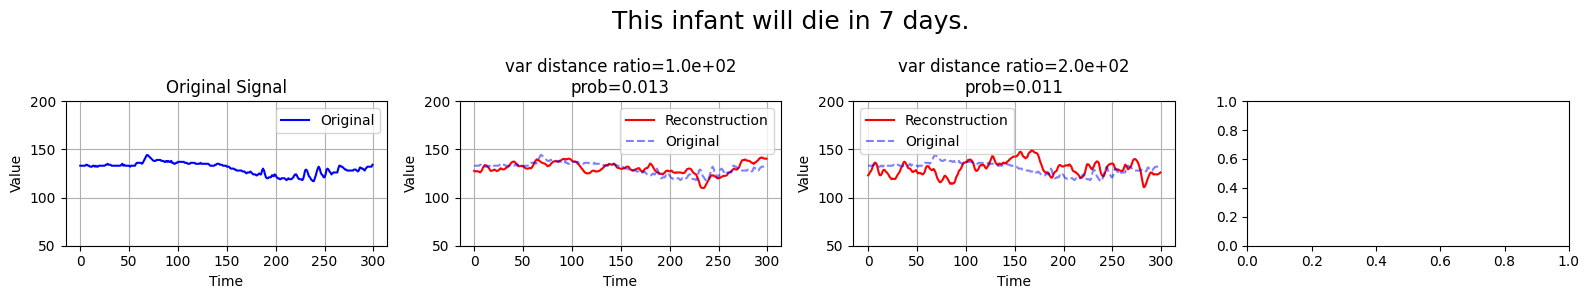

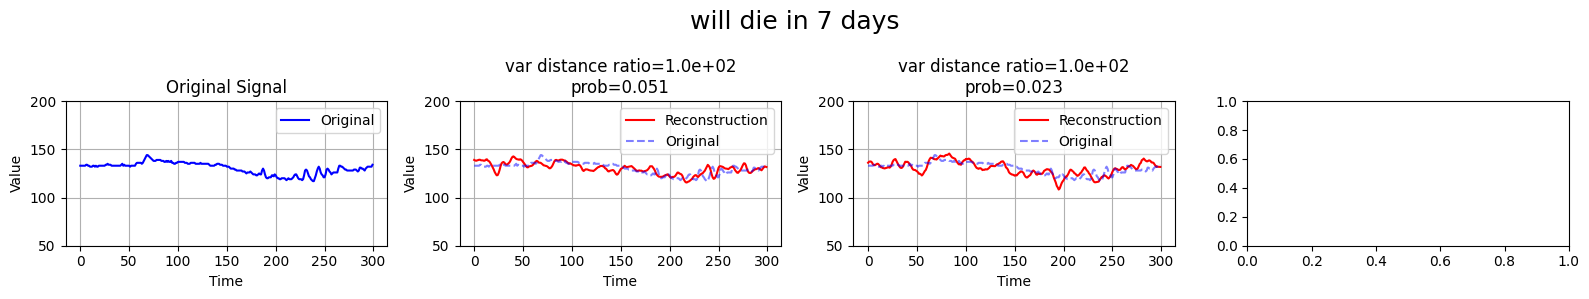

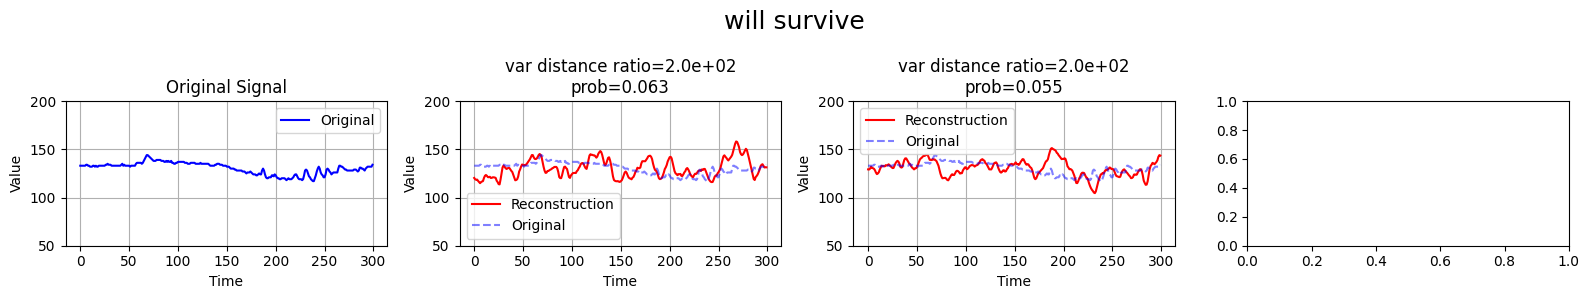

In [12]:
df = df_infer.iloc[[i]].copy()
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['cl_event'].tolist()[0])

df['text1'] = "will die in 7 days"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['text1', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])
df['text2'] = "will survive"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['text2', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0])

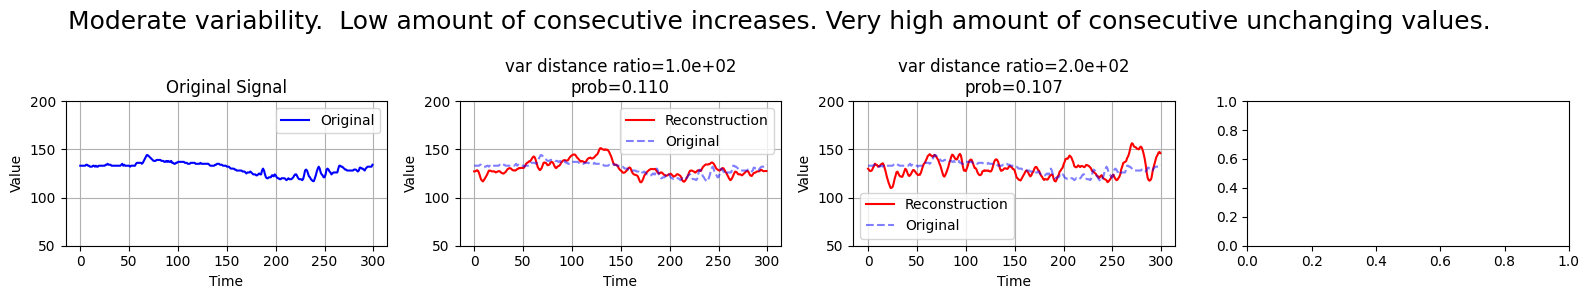

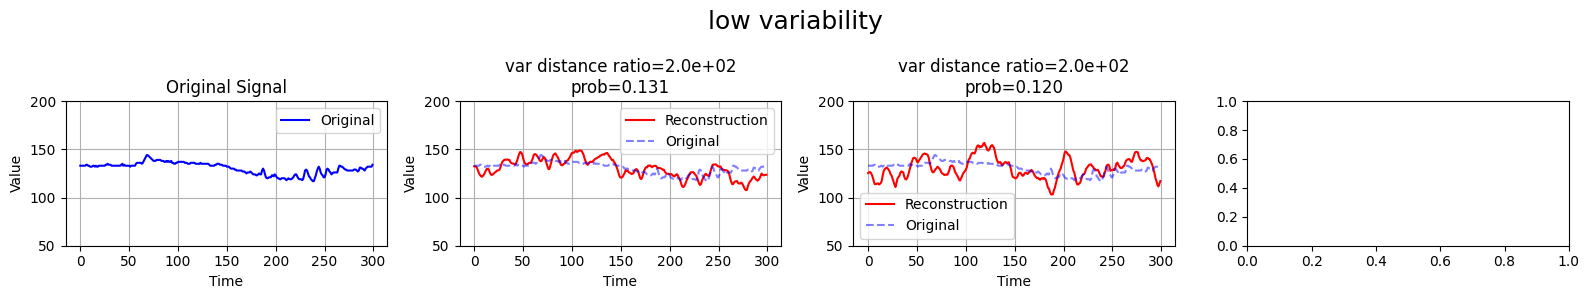

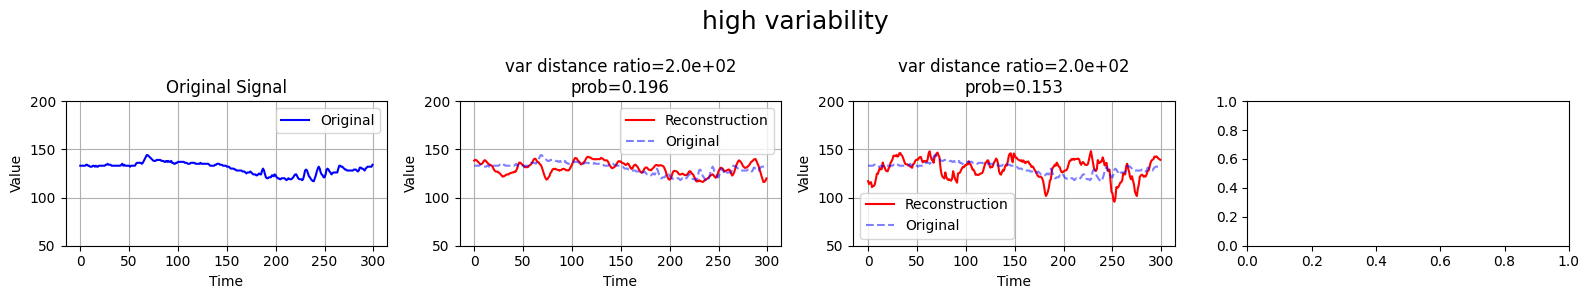

In [397]:
df = df_infer.iloc[[i]].copy()
# df.loc[:,'1':'300'] = np.random.randint(160, 170, size=(df.shape[0], 300))# 300 random integers between 160 and 165
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['ts_description'].tolist()[0])

df['text1'] = "low variability"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0])
df['text2'] = "high variability"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text2', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop,
                                                             keep = keep)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0])


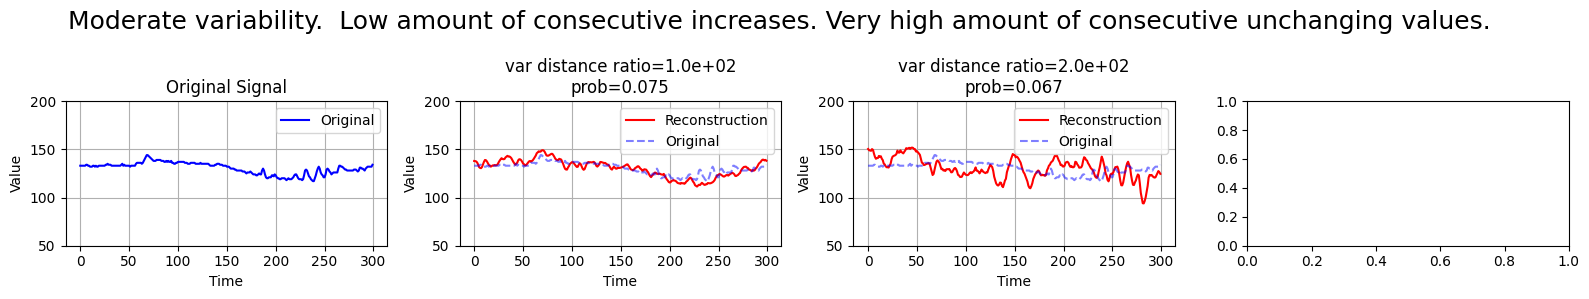

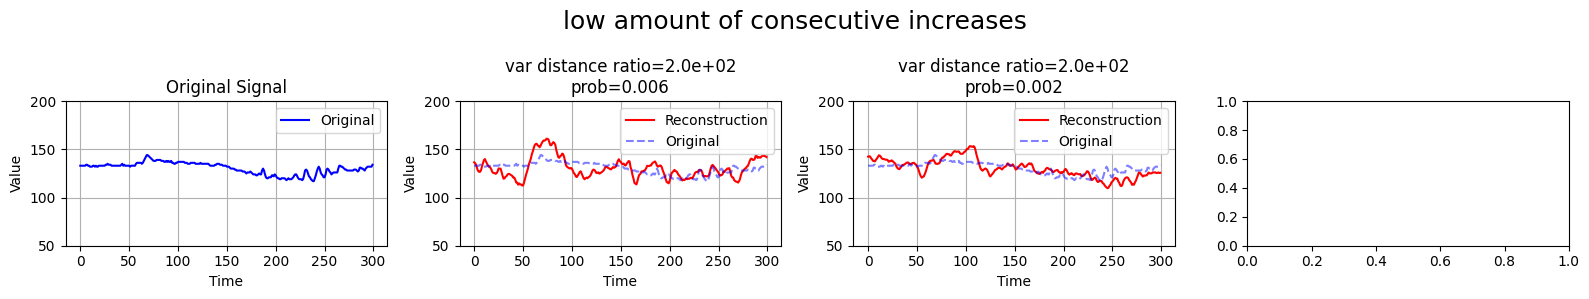

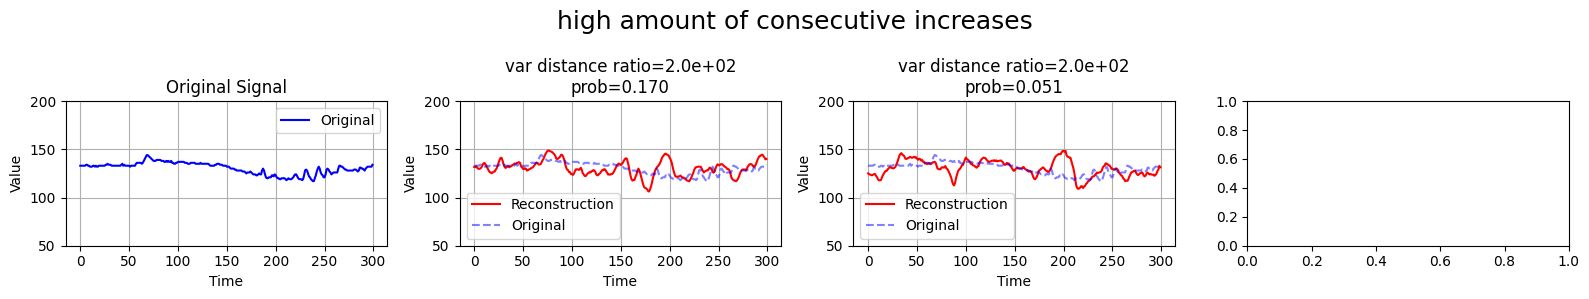

In [398]:
df = df_infer.iloc[[i]].copy()
# df.loc[:,'1':'300'] = np.random.randint(160, 170, size=(df.shape[0], 300))# 300 random integers between 160 and 165
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict, 
                                                              text_col_ls=['cl_event', 'ts_description', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['ts_description'].tolist()[0], keep=keep)

df['text1'] = "low amount of consecutive increases"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text1', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text1'].tolist()[0], keep=keep)

df['text2'] = "high amount of consecutive increases"
ts, top_probs, top_ts_hats, top_distance_ratios = vital_infer(df, model, config_dict,
                                                              text_col_ls=['cl_event', 'text2', 'demo'],
                                                             distance_ratios = distance_ratios,
                                                             threshold = threshold,
                                                              poptop = poptop)
plot_vital_reconstructions(ts, top_probs, top_ts_hats, top_distance_ratios, title=df['text2'].tolist()[0], keep=keep)


# visualize training and testing ts embeddings in networks

In [ ]:
def dot_product_similarity(model, df, config_dict, dataloader = None):
    model.eval()

    # prepare ts_f and tx_f
    if dataloader is None:

        if config_dict['3d']:
            ts_f, tx_f_ls, _ = get_features3d(df, config_dict, text_col_ls = config_dict['text_col_ls'])
            ts_f = ts_f.to(device)
            tx_f_ls = [tx_f.to(device) for tx_f in tx_f_ls]
        else:
            ts_f, tx_f, _ = get_features(df, config_dict, text_col = config_dict['text_col'])
            ts_f = ts_f.to(device)
            tx_f = tx_f.to(device)
    
    else:
        ts_f = None
        tx_f = None
            
        if config_dict['3d']:
        
            for _, (_, ts, text_features, _, _) in enumerate(dataloader):
                if ts_f is None:
                    ts_f  = ts
                else: 
                    ts_f = torch.cat([ts_f, ts], dim=0)
                if tx_f is None:
                    tx_f = text_features
                else: 
                    tx_f = [torch.cat([tx_f[i], text_features[i]], dim=0) for i in range(len(tx_f))]
        else:
            
            for _, (_, ts, text_features, _, _) in enumerate(dataloader):
                if ts_f is None:
                    ts_f  = ts
                else: 
                    ts_f = torch.cat([ts_f, ts], dim=0)
                if tx_f is None:
                    tx_f = text_features
                else: 
                    tx_f = torch.cat([tx_f, text_features], dim=0)

    # get z_means for ts_f
    _, z_mean, _, _, _ = model.ts_encoder(ts_f)
    # get c for tx_f_ls or tx_f
    c, _ = model.text_encoder(tx_f)

    # z_means is dim (N, embed_dim) get dot product similarity between z_means using clip
    dps_zc = model.clip(z_mean, c)
    dps_zz = model.clip(z_mean, z_mean)
    dps_cc = model.clip(c, c)
    
    # take exp of dps_zc, dps_zz, dps_cc
    dps_zc = torch.exp(dps_zc)
    dps_zz = torch.exp(dps_zz)
    dps_cc = torch.exp(dps_cc)
    
    # # normalize exp_dps_zc, exp_dps_zz, exp_dps_cc
    # exp_dps_zc = exp_dps_zc / exp_dps_zc.sum(dim=1, keepdim=True)
    # exp_dps_zz = exp_dps_zz / exp_dps_zz.sum(dim=1, keepdim=True)
    # exp_dps_cc = exp_dps_cc / exp_dps_cc.sum(dim=1, keepdim=True)



# okay, dps_zc is an adjacency matrix now, plot a network on this weighted N x N matrix 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to numpy if not already
if torch.is_tensor(dps_zc):
    dps_zc = dps_zc.cpu().detach().numpy()

# Get upper triangle values (excluding diagonal)
upper_triangle = dps_zc[np.triu_indices_from(dps_zc, k=1)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(upper_triangle, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Density')

# Add summary statistics
print(f"Summary Statistics:")
print(f"Mean: {upper_triangle.mean():.3f}")
print(f"Median: {np.median(upper_triangle):.3f}")
print(f"Std: {upper_triangle.std():.3f}")
print(f"Min: {upper_triangle.min():.3f}")
print(f"Max: {upper_triangle.max():.3f}")

# Optional: Add vertical lines for potential thresholds
percentiles = [25, 50, 75]
for p in percentiles:
    threshold = np.percentile(upper_triangle, p)
    plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.3)
    plt.text(threshold, plt.ylim()[1], f'{p}th', rotation=0)

plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def prepare_for_gephi(dps, threshold=0, output_prefix="network"):
    """
    Convert similarity matrix to Gephi-compatible CSV files
    Creates two files:
    - nodes.csv: node list with IDs
    - edges.csv: edge list with weights
    """
    # Convert to numpy if tensor
    if torch.is_tensor(dps):
        adj_matrix = dps.cpu().detach().numpy()
    else:
        adj_matrix = dps
    
    # Create nodes dataframe
    nodes_df = pd.DataFrame({
        'Id': range(len(adj_matrix)),
        'Label': range(len(adj_matrix))
    })
    
    # Create edges dataframe
    edges = []
    for i in range(len(adj_matrix)):
        for j in range(i+1, len(adj_matrix)):  # upper triangle only
            weight = adj_matrix[i,j]
            if weight > threshold:
                edges.append({
                    'Source': i,
                    'Target': j,
                    'Weight': weight,
                    'Type': 'Undirected'
                })
    
    edges_df = pd.DataFrame(edges)
    
    # Save to CSV
    nodes_df.to_csv(f"{output_dir}/{output_prefix}_nodes.csv", index=False)
    edges_df.to_csv(f"{output_dir}/{output_prefix}_edges.csv", index=False)
    
    print(f"Created {len(nodes_df)} nodes and {len(edges_df)} edges")
    print(f"Files saved as {output_prefix}_nodes.csv and {output_prefix}_edges.csv")
    
    return nodes_df, edges_df


thresh = 20
nodes, edges = prepare_for_gephi(dps_zc, 
                               threshold=thresh,
                               output_prefix=f"network_thresh_{thresh}")



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_similarity_network(adj_matrix, threshold=0.5, max_nodes=100, node_size=100, figsize=(12, 12)):
    """
    Plot network from similarity matrix with weighted edges
    
    Args:
        adj_matrix: torch.Tensor, similarity matrix (N x N)
        threshold: float, minimum similarity to draw edge
        max_nodes: int, maximum number of nodes to plot
        node_size: int, size of nodes in visualization
        figsize: tuple, figure size
    """
    # Convert to numpy if tensor
    if torch.is_tensor(adj_matrix):
        adj_matrix = adj_matrix.cpu().detach().numpy()
    else:
        adj_matrix = adj_matrix

    # If matrix is too large, take first max_nodes
    if adj_matrix.shape[0] > max_nodes:
        adj_matrix = adj_matrix[:max_nodes, :max_nodes]
    
    # Create graph
    G = nx.Graph()
    
    # Add edges with weights above threshold
    n = adj_matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):  # Upper triangle only (undirected graph)
            if adj_matrix[i,j] > threshold:
                G.add_edge(i, j, weight=adj_matrix[i,j])
    
    # Get position layout
    pos = nx.spring_layout(G, k=1/np.sqrt(n), iterations=50)
    
    # Plot
    plt.figure(figsize=figsize)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          node_color='lightblue',
                          node_size=node_size)
    
    # Draw edges with width proportional to weight
    edges = G.edges()
    weights = [G[u][v]['weight'] for u,v in edges]
    
    # Normalize edge widths
    max_width = 5
    min_width = 0.1
    if weights:  # Check if there are any edges
        normalized_weights = [(w-min(weights))/(max(weights)-min(weights))*(max_width-min_width)+min_width 
                            for w in weights]
    else:
        normalized_weights = []
    
    nx.draw_networkx_edges(G, pos, 
                          width=normalized_weights,
                          alpha=0.5,
                          edge_color='gray')
    
    # Add labels
    nx.draw_networkx_labels(G, pos, 
                           font_size=8)
    
    plt.title(f'Similarity Network (threshold={threshold})\nNodes: {n}, Edges: {len(edges)}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

# # Plot with different thresholds
# thresholds = [0.3, 0.5, 0.7]
# for thresh in thresholds:
#     G = plot_similarity_network(dps_zc, 
#                               threshold=thresh,
#                               max_nodes=50,  # Adjust based on your data
#                               node_size=200)
#     print(f"\nThreshold {thresh}:")
#     print(f"Number of nodes: {G.number_of_nodes()}")
#     print(f"Number of edges: {G.number_of_edges()}")
#     print(f"Average degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

# # Optional: Calculate and print network metrics
# def print_network_metrics(G):
#     print("\nNetwork Metrics:")
#     print(f"Density: {nx.density(G):.3f}")
#     print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
    
#     # Calculate connected components
#     components = list(nx.connected_components(G))
#     print(f"Number of connected components: {len(components)}")
#     print(f"Largest component size: {len(max(components, key=len))}")
    
#     # Calculate degree distribution
#     degrees = [d for n, d in G.degree()]
#     plt.figure(figsize=(8, 4))
#     plt.hist(degrees, bins=20)
#     plt.title('Degree Distribution')
#     plt.xlabel('Degree')
#     plt.ylabel('Count')
#     plt.show()

# Print metrics for middle threshold
G_mid = plot_similarity_network(dps_zc, threshold=0.5)
print_network_metrics(G_mid)